In [1]:
setwd('/import/GSE213982_fel/')

In [2]:
library(CellChat)
library(tidyverse)
library(Seurat)
options(stringsAsFactors = FALSE)

Loading required package: dplyr

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v purrr   1.0.1
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
W

In [3]:
sce = readRDS('/import/GSE213982_fel/final.rds')

In [4]:
table(sce$group)


    F     M 
81653 79058 

In [5]:
Idents(sce) = 'group'
sce = subset(sce,idents = 'F')

In [6]:
cellchat <- createCellChat(object = sce,
                           meta = sce@meta.data,
                           group.by = "celltype")
cellchat

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Ast End ExN InN Mic Mix OPC Oli 


An object of class CellChat created from a single dataset 
 33562 genes.
 81653 cells. 
CellChat analysis of single cell RNA-seq data! 

In [7]:
CellChatDB <- CellChatDB.human  
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

In [8]:
library(future)

Warning message:
"package 'future' was built under R version 4.2.3"

Attaching package: 'future'


The following objects are masked from 'package:igraph':

    %->%, %<-%




In [9]:
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=50)

In [10]:
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
cellchat <- projectData(cellchat, PPI.human)

In [11]:
library(future)
options(future.globals.maxSize= 4000000000)

In [12]:
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 10)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-04-28 08:32:10]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-04-28 09:04:28]"


In [13]:
df.net <- subsetCommunication(cellchat)
write.csv(df.net, "cell-cell_communications.all.FEMALE.csv")

In [14]:
cellchat <- computeCommunProbPathway(cellchat)
#计算整合的细胞类型之间通信结果
cellchat <- aggregateNet(cellchat)

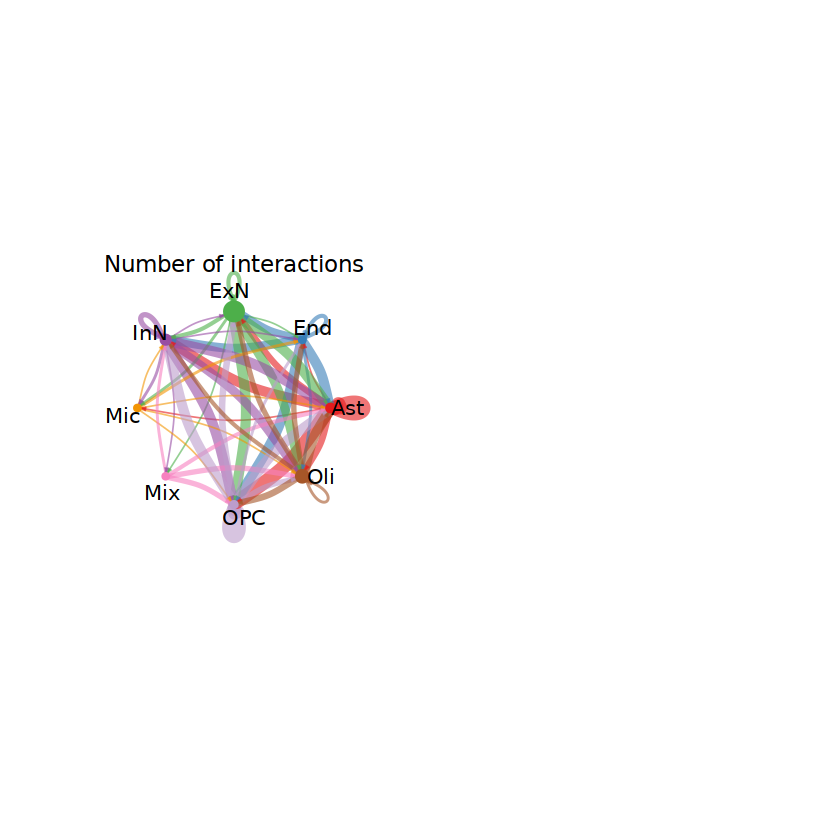

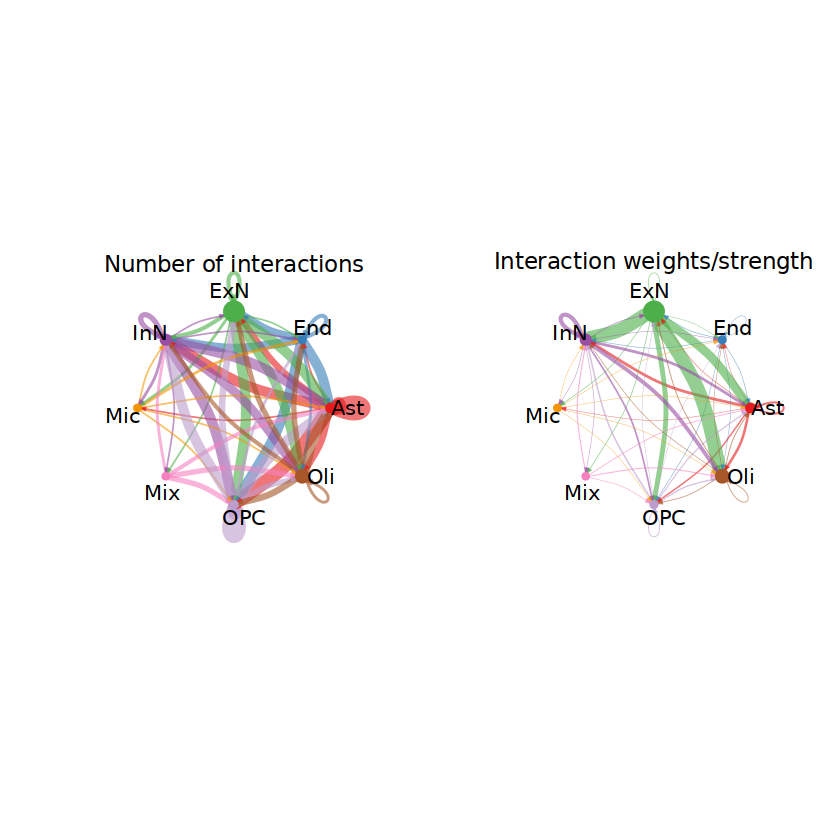

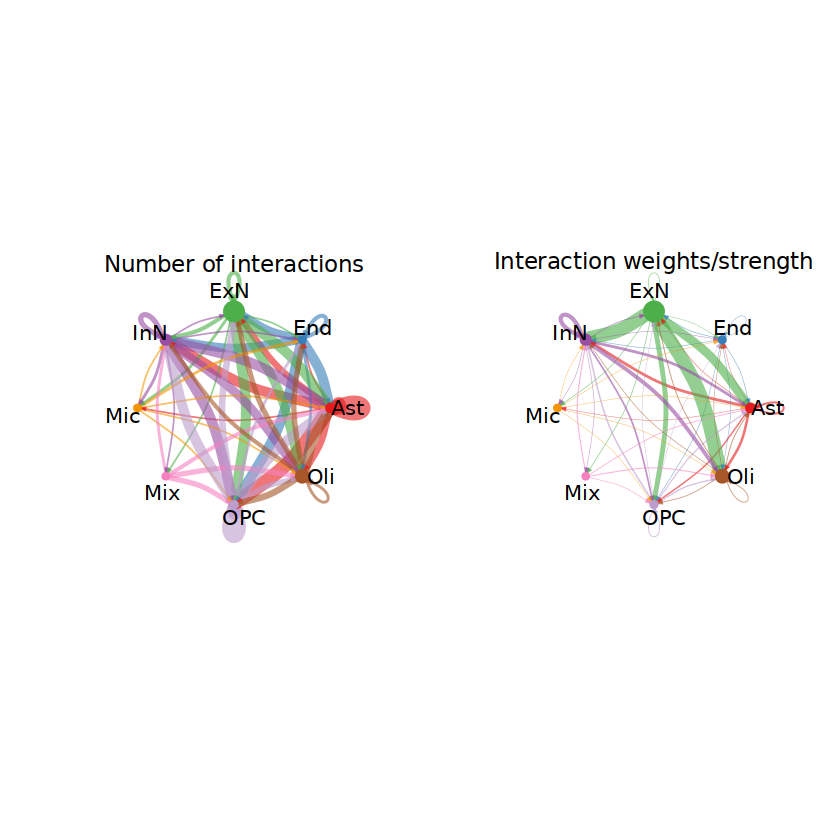

In [15]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, 
                 weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, 
                 weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

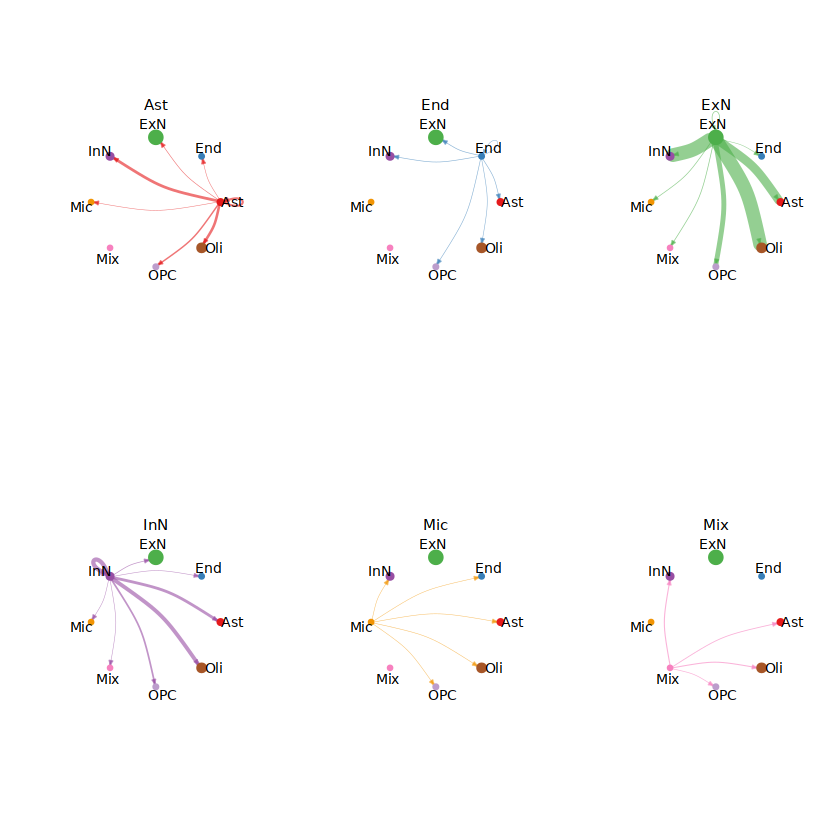

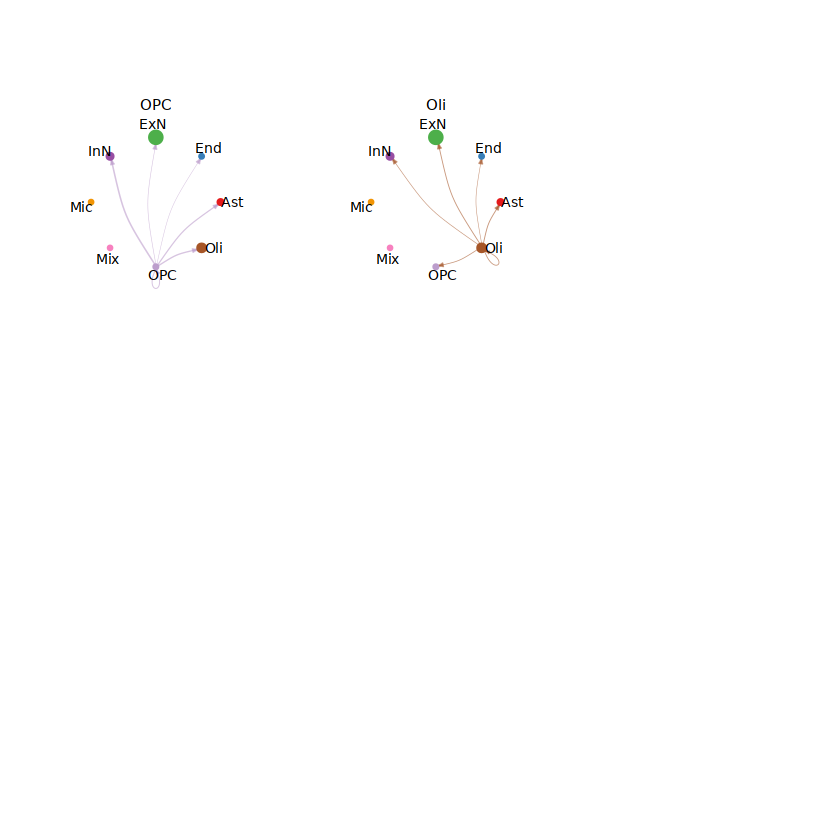

In [16]:
mat <- cellchat@net$weight
par(mfrow = c(2,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}